# Data Smoothing and Interpolation

Sometimes Data can be noisy. When using data sets of observations that describe a trend but have no obvious mathematical function for a curve fit, how can we establish result values between data points.  One way is to draw a smooth curve through the data and then eyeball the value from that curve. However that way does not allow for automation.

Let us first consider a data set of acidity values for various mixtures of acetic acid and sulfuric acid. The original data can be found at "The Acidity Scale in Glacial Acetic Acid. I. Sulfuric Acid Solutions. $-6 < H_0 < 0$." Norris F. Hall and Willard F. Spengeman, *J. Am. Chem. Soc.*, **1940**, *62*, 2487-2492. [https://doi.org/10.1021/ja01866a062](https://doi.org/10.1021/ja01866a062)

I am interested in extracting a set of $H_0$ value in the range of $-4.5 < H_0 < -3.5$ so that I can convert a set of acid mixtures to their $H_0$ value. As you can see, the literature data is noisy. The authors used a pen to draw the "best line". We will use a documented algorithm that can be interpretted and criticized by readers. perhaps others would do it differently and they will all have the information on exactly how I chose to do this. 

## Interpolation

We could simply apply an interpolation function to the data. We could interpolate with straight lines ("connect the dots") or by the cubic spline method. In the code below you will see both examples. In both cases we might fail to get something that would land on that "hand-drawn" curve. Consider the data set below for the $H_0$ value of various $\rm HOAc$/$\rm H_2SO_4$ mixtures. First I will present the raw data and then two methods for interpolating. Both of them are terrible, but which do you consider to be the worst?



,%H2SO4,H0,indicator,indicator_pKa
59,0.030,0.05,2-nitroaniline,-0.17
0,0.031,0.09,4-chloro-2-nitroaniline,-0.91
1,0.050,-0.14,4-chloro-2-nitroaniline,-0.91
60,0.055,-0.30,2-nitroaniline,-0.17
61,0.090,-0.60,2-nitroaniline,-0.17
...,...,...,...,...
30,43.450,-5.46,"2,4-dichloro-6-nitroaniline",-3.67
58,43.710,-5.57,"N,N-Dimethyl-2,3,6-trinitroaniline",-4.73
45,46.040,-5.64,"2,6-dinitro-4-methylaniline",-4.45
46,48.940,-5.91,"2,6-dinitro-4-methylaniline",-4.45


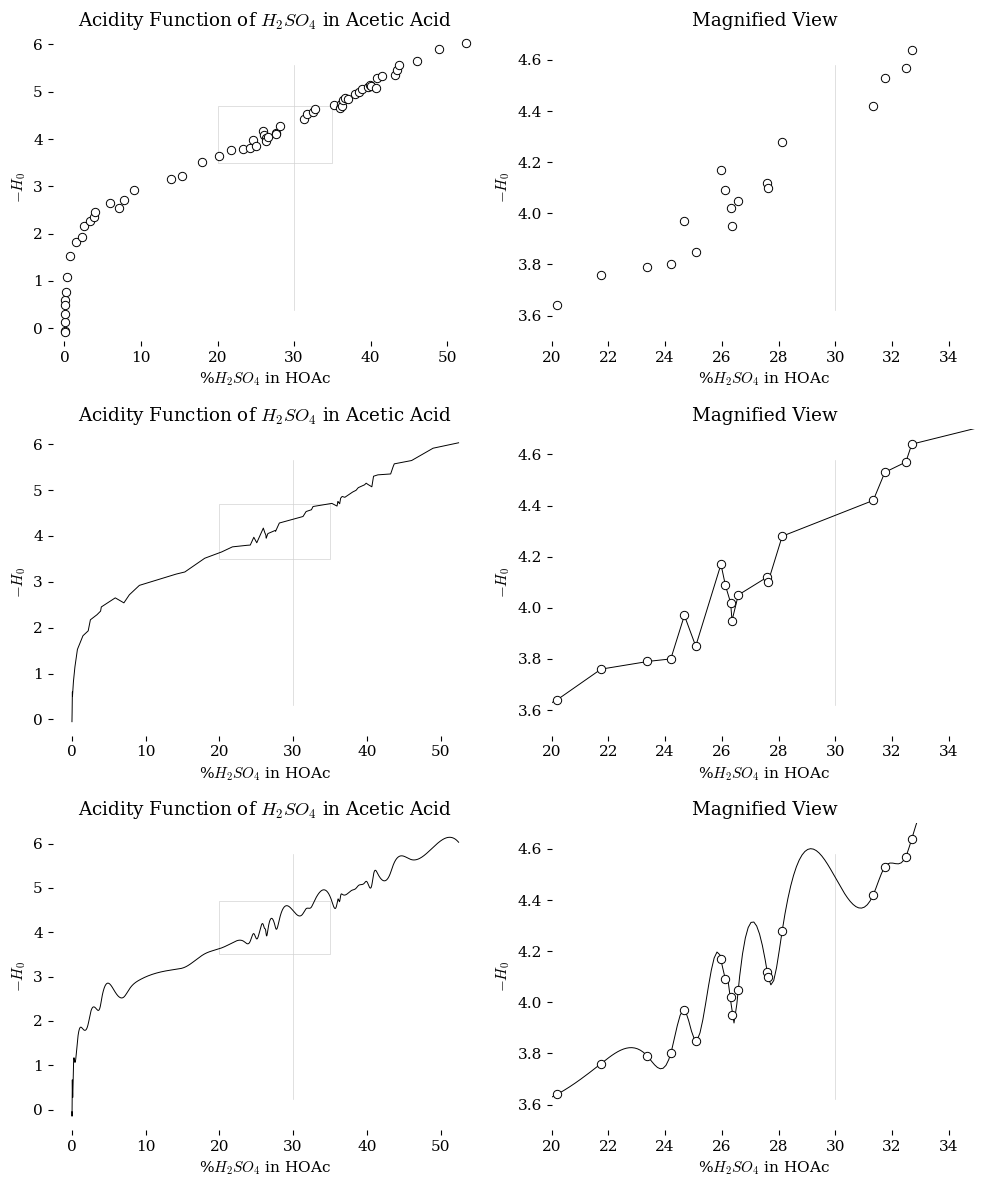

In [10]:
file_path = ""
file_name = "AceticAcid_H2SO4_H0_Values.csv"  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

from statsmodels.nonparametric.smoothers_lowess import lowess     # A function for interpolating a plot using the locally weighed scatterplot smoothing method
from scipy.interpolate import CubicSpline                         # A function for interpolating a plot using the cubic spline method
from scipy.interpolate import interp1d                            # A function for interpolating a plot using the connect-the-dots method

from matplotlib.patches import PathPatch
from matplotlib.path import Path

############################
### Set global variables ###
############################

data_path = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_08/data/"
image_path = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_08/images/"

github_data_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"
github_styles_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"

############################


df = pd.read_csv(data_path+file_name, skipinitialspace=True, comment='#') 
#display(df)

df.sort_values(by=['%H2SO4'], inplace=True)
#display(df)

y = -df['H0']
x = df['%H2SO4']

display(df)
style_file_path = github_styles_location

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"

plt.style.use(style_file_path+style)        
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,12))  

###########################
### Set up rectangles
###########################

vertices = []
codes = []

codes = [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY]
vertices = [(20, 3.5), (20, 4.7), (35, 4.7), (35, 3.5), (0, 0)]

path = Path(vertices, codes)
pathpatch0 = PathPatch(path, edgecolor='lightgray', facecolor='white', linewidth=0.5, zorder = 0)
pathpatch1 = PathPatch(path, edgecolor='lightgray', facecolor='white', linewidth=0.5, zorder = 0)
pathpatch2 = PathPatch(path, edgecolor='lightgray', facecolor='white', linewidth=0.5, zorder = 0)


ax[0][0].add_patch(pathpatch0)
ax[1][0].add_patch(pathpatch1)
ax[2][0].add_patch(pathpatch2)

###########################
### Plot data as points ###
###########################

ax[0][0].set(title=r"Acidity Function of $H_2SO_4$ in Acetic Acid",       
       ylabel=r"$-H_0$", 
       xlabel="%$H_2SO_4$ in HOAc",                
#       xlim=[2,10],                  
#       ylim=[17,21.5]
      )                   

ax[0][0].scatter(x,y, marker = "o", color = "white", edgecolors = "black", linewidths=0.7)

ax[0][0].axvline(x=30, ymin=0.1, ymax = 0.9, linewidth = 0.5, color = "lightgray")


ax[0][0].margins(x=.03, y=.03, tight=True)

#####################################
### Plot zoomed in data as points ###
#####################################

ax[0][1].set(title=r"Magnified View",       
       ylabel=r"$-H_0$", 
       xlabel="%$H_2SO_4$ in HOAc",                
       xlim=[20,35],                  
       ylim=[3.5,4.7]
      )                   

ax[0][1].scatter(x,y, marker = "o", color = "white", edgecolors = "black", linewidths=0.7)

ax[0][1].axvline(x=30, ymin=0.1, ymax = 0.9, linewidth = 0.5, color = "lightgray")
ax[0][1].margins(x=.03, y=.03, tight=True)

#########################################

#########################################
### Interpolation by straight lines
#########################################

ax[1][0].set(title=r"Acidity Function of $H_2SO_4$ in Acetic Acid",       
       ylabel=r"$-H_0$", 
       xlabel="%$H_2SO_4$ in HOAc",                
#       xlim=[2,10],                  
#       ylim=[17,21.5]
      )                   

## Interpolate plot points. We can use a linear interpolation between points or cubic spline

interpolation = interp1d(x, y, kind='linear')

x1 = np.arange(np.min(x), np.max(x), 0.01)
#print(x)
y1 = interpolation(x1)

ax[1][0].axvline(x=30, ymin=0.1, ymax = 0.9, linewidth = 0.5, color = "lightgray", zorder = 0)

ax[1][0].plot(x1, y1, "-", color = "black", linewidth=0.7, zorder = 1)



#########################################
### Zoomed in
#########################################

ax[1][1].set(title=r"Magnified View",       
       ylabel=r"$-H_0$", 
       xlabel="%$H_2SO_4$ in HOAc",                
       xlim=[20,35],                  
       ylim=[3.5,4.7]
      )                   

## Interpolate plot points. We can use a linear interpolation between points or cubic spline



ax[1][1].axvline(x=30, ymin=0.1, ymax = 0.9, linewidth = 0.5, color = "lightgray", zorder = 0)

ax[1][1].plot(x1, y1, "-", color = "black", linewidth=0.7, zorder = 1)

ax[1][1].scatter(x,y, marker = "o", color = "white", edgecolors = "black", linewidths=0.7, zorder = 2)


#########################################

#########################################
### Interpolation by cubic splines
#########################################

ax[2][0].set(title=r"Acidity Function of $H_2SO_4$ in Acetic Acid",       
       ylabel=r"$-H_0$", 
       xlabel="%$H_2SO_4$ in HOAc",                
#       xlim=[2,10],                  
#       ylim=[17,21.5]
      )                   

## Interpolate plot points. We can use a linear interpolation between points or cubic spline

interpolation = CubicSpline(x, y)

x1 = np.arange(np.min(x), np.max(x), 0.01)
#print(x)
y1 = interpolation(x1)

ax[2][0].plot(x1, y1, "-", color = "black", linewidth=0.7)

ax[2][0].axvline(x=30, ymin=0.1, ymax = 0.9, linewidth = 0.5, color = "lightgray", zorder = 0)



#########################################
### Interpolation by cubic splines
#########################################

ax[2][1].set(title=r"Magnified View",       
       ylabel=r"$-H_0$", 
       xlabel="%$H_2SO_4$ in HOAc",                
       xlim=[20,35],                  
       ylim=[3.5,4.7]
      )                   

## Interpolate plot points. We can use a linear interpolation between points or cubic spline

interpolation = CubicSpline(x, y)

x1 = np.arange(np.min(x), np.max(x), 0.1)
#print(x)
y1 = interpolation(x1)

ax[2][1].axvline(x=30, ymin=0.1, ymax = 0.9, linewidth = 0.5, color = "lightgray", zorder = 0)

ax[2][1].plot(x1, y1, "-", color = "black", linewidth=0.7, zorder = 1)

ax[2][1].scatter(x,y, marker = "o", color = "white", edgecolors = "black", linewidths=0.7, zorder = 2)








plt.savefig("fig.pdf")
plt.show()

## Data Smoothing

You can see the awful truth of interpolation. It generates data between every point but, by definition, the line must pass through every point. In noisy data we do not want that. We will use another method now that "averages" the data at every point (for more on that see the link below)

**Note**: the code below includes a data smoothing method to create the line.  The line is not a line fit, it is a smoothed representation of the data. I stole the code from [here](https://towardsdatascience.com/data-smoothing-for-data-science-visualization-the-goldilocks-trio-part-1-867765050615).





[0.03, 0.031, 0.05, 0.055, 0.09, 0.097, 0.193, 0.385, 0.756, 1.5, 2.23, 2.52, 3.35, 3.91, 4.0, 5.89, 7.07, 7.77, 9.14, 13.96, 15.3, 17.98, 20.19, 21.74, 23.37, 24.2, 24.68, 25.08, 25.97, 26.12, 26.31, 26.36, 26.58, 27.6, 27.63, 28.13, 31.34, 31.75, 32.49, 32.7, 35.24, 35.96, 36.08, 36.32, 36.44, 36.64, 37.01, 38.0, 38.52, 38.82, 39.67, 39.9, 40.06, 40.68, 40.9, 41.45, 43.23, 43.45, 43.71, 46.04, 48.94, 52.45]
[0.023534465621811593, 0.02847088227637963, 0.12178007659612249, 0.146202837659558, 0.3160076112621152, 0.3497586897878496, 0.7747802887251719, 1.0938112876953259, 1.5265935231740329, 1.7543211315563607, 1.9965167354358924, 2.065129844574074, 2.2676327288746485, 2.3668721464098006, 2.38379383758955, 2.55744483273874, 2.6728616429955636, 2.7391867902104607, 2.853435808397888, 3.1735367272699655, 3.2659274318752693, 3.4659224773856647, 3.6431869742804923, 3.728726452237844, 3.8097429231708744, 3.84530361623574, 3.884509561332629, 3.937113889588796, 4.00987793899494, 4.02869622099027

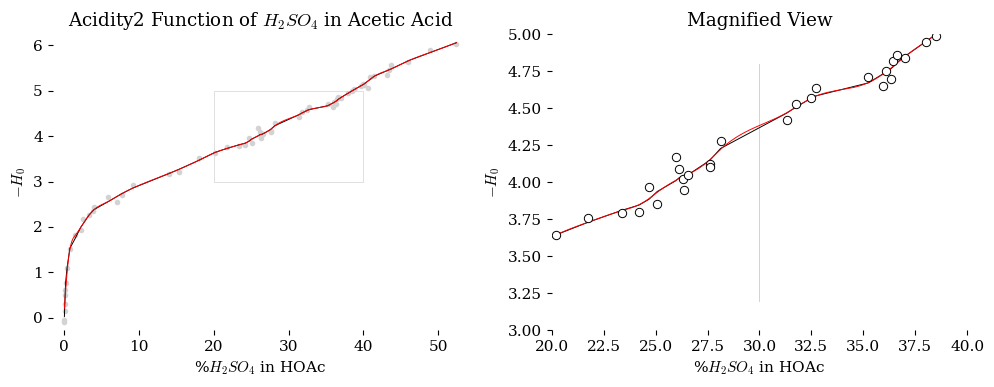

In [44]:
y1 = list(-df['H0'])
x1 = list(df['%H2SO4'])

#fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(10,4))  

plt.style.use(style_file_path+style)        
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))  

###########################
### Set up rectangles
###########################

vertices = []
codes = []

#zoom_xlim=[-0.5,5]                  
#zoom_ylim=[0,3]

zoom_xlim=[20,40]                  
zoom_ylim=[3,5]

vertices = []
codes = []

codes = [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY]
vertices = [(zoom_xlim[0], zoom_ylim[0]), 
            (zoom_xlim[0], zoom_ylim[1]), 
            (zoom_xlim[1], zoom_ylim[1]), 
            (zoom_xlim[1], zoom_ylim[0]), 
            (0, 0)]

path = Path(vertices, codes)
pathpatch0 = PathPatch(path, edgecolor='lightgray', facecolor='white', linewidth=0.5, zorder = 0)


ax[0].add_patch(pathpatch0)


###################################
### Data smoothing using LOWESS ###
###################################

# See https://towardsdatascience.com/data-smoothing-for-data-science-visualization-the-goldilocks-trio-part-1-867765050615
#########################################
lowess_smooth = lowess(y1, x1, frac = .13)
#########################################

#x2 = lowess_smooth[:,0]
#y2 = lowess_smooth[:,1]

#print (len(lowess_smooth[:,0]))
x2 = list(lowess_smooth[:,0])
y2 = list(lowess_smooth[:,1])

#x2 = x2[::5]
#y2 = y2[::5]

print(x2)
print(y2)

#ax[0][0].plot(x2,y2,"k-")
ax[0].plot(x2, y2, "-", color = "black", linewidth=0.7, zorder = 1)

###########################
### Plot data as points ###
###########################

ax[0].set(title=r"Acidity2 Function of $H_2SO_4$ in Acetic Acid",       
       ylabel=r"$-H_0$", 
       xlabel="%$H_2SO_4$ in HOAc",                
#       xlim=[2,10],                  
#       ylim=[17,21.5]
      )                   

ax[0].plot(x1,y1,".", color = "lightgray", zorder = 0)
#ax[0].scatter(x2,y2, marker = "o", color = "white", edgecolors = "black", linewidths=0.7, zorder = 2)

ax[1].axvline(x=30, ymin=0.1, ymax = 0.9, linewidth = 0.5, color = "lightgray", zorder = 0)

ax[0].margins(x=.03, y=.03, tight=True)

#########################################
### Zoomed in
#########################################

ax[1].set(title=r"Magnified View",
       ylabel=r"$-H_0$", 
       xlabel="%$H_2SO_4$ in HOAc",
#       xlim=[20,35],
#       ylim=[3.5,4.7]
       xlim = zoom_xlim,
       ylim = zoom_ylim
      )

## Interpolate plot points. We can use a linear interpolation between points or cubic spline



ax[1].axvline(x=30, ymin=0.1, ymax = 0.9, linewidth = 0.5, color = "lightgray", zorder = 0)

ax[1].plot(x2, y2, "-", color = "black", linewidth=0.7, zorder = 1)

ax[1].scatter(x1,y1, marker = "o", color = "white", edgecolors = "black", linewidths=0.7, zorder = 2)

#########################################
### Interpolation by  Bsplines
#########################################


## Interpolate plot points. We can use a Bspline.

weights = np.ones_like(x2)
weights[0:4] = 0.01
weights[0] = 1
#weights[4:] = .1
print(weights)

interpolation = scipy.interpolate.make_smoothing_spline(x2, y2, w=weights, lam=0.02)
# NO GOOD # interpolation = scipy.interpolate.UnivariateSpline(x2, y2, w=None, bbox=[None, None], k=4, s=None, ext=0, check_finite=False)
#interpolation = CubicSpline(x2, y2)

x3 = np.arange(np.min(x2), np.max(x2), 0.1)
#print(x)
y3 = interpolation(x3)

ax[1].axvline(x=30, ymin=0.1, ymax = 0.9, linewidth = 0.5, color = "lightgray", zorder = 0)

ax[0].plot(x3, y3, "-", color = "red", linewidth=0.7, zorder = 1)

ax[1].plot(x3, y3, "-", color = "red", linewidth=0.7, zorder = 1)

#ax[1].scatter(x1,y1, marker = "o", color = "white", edgecolors = "black", linewidths=0.7, zorder = 2)

#########################################

plt.show()

In [46]:
x2[::15]

[0.03]


The acidity increases rapidly as $H_2SO_4$ is added because it is an extremely strong acid. It won't take much to triple the value of $k_{obs}$.

## Rate vs. $H_0$

The $H_0$ of neat acetic acid is 0.2. Every 0.5 log units is about a 3-fold difference in protonating power. So we are shooting for an $H_0$ of -0.3. I checked the data table for the plot above and found an acid mixture that results in an $H_0$ near –0.3.

In [3]:
display(df)

,%H2SO4,H0,indicator,indicator_pKa
59,0.030,0.05,2-nitroaniline,-0.17
0,0.031,0.09,4-chloro-2-nitroaniline,-0.91
1,0.050,-0.14,4-chloro-2-nitroaniline,-0.91
60,0.055,-0.30,2-nitroaniline,-0.17
61,0.090,-0.60,2-nitroaniline,-0.17
...,...,...,...,...
30,43.450,-5.46,"2,4-dichloro-6-nitroaniline",-3.67
58,43.710,-5.57,"N,N-Dimethyl-2,3,6-trinitroaniline",-4.73
45,46.040,-5.64,"2,6-dinitro-4-methylaniline",-4.45
46,48.940,-5.91,"2,6-dinitro-4-methylaniline",-4.45


It appears that if I use a 0.055% mixture I will have $H_0 = 0.30$. Let us calculate the new value of $k_{obs}$.

The rate will triple if the value of $k_{obs}$ triples

$$\frac{\partial}{\partial t}\left[P\right]=k_{obs}\left[B_{t}\right]$$

and

$$k_{obs}=k_1 \frac{\left[H^+\right]}{K_a + \left[H^+\right]}$$

The typical $pK_a$ value of a protonated alcohol in water is near $-2$ in water.  I will assume that it is similar in acetic acid so I will state that $pK_a = -2$ 

We can write the equation for $k_{obs}$ in terms of out logarithmic parameters like so$\ldots$

$$k_{obs}=k_1 \frac{10^{-H_0}}{10^{-pK_a} + 10^{-H_0}}$$

We don't know $k_1$ but we know $H_0$ and $K_a$. We can state that$\ldots$ 

$$k_{obs}=k_1 \cdot f$$

where

$$f= \frac{10^{-H_0}}{10^{-pK_a} + 10^{-H_0}}$$

So we can calculate the realtive value of $k_{obs}$ in the two acid mixtures using the code below.



In [4]:
H0 = 0.2
pKa = -2

# calculate the Kobs in terms of k1.

f = 10**(-H0)/(10**(-pKa)+10**(-H0))

print(f"The value of k_obs at H0 = {H0:0.2f} is k1*{f:0.4f}")

H0 = -.3
pKa = -2

# calculate the Kobs in terms of k1.

f2 = 10**(-H0)/(10**(-pKa)+10**(-H0))

print(f"The value of k_obs at H0 = {H0:0.2f} is k1*{f2:0.4f}")

ratio = f2/f

print(f"The ratio of the kobs values is {ratio:0.2f}")

The value of k_obs at H0 = 0.20 is k1*0.0063
The value of k_obs at H0 = -0.30 is k1*0.0196
The ratio of the kobs values is 3.12


Is it true that if we triple the acidity again we will triple the rate again? Lets just copy and paste and try it.

In [5]:
H0 = -0.3
pKa = -2

# calculate the Kobs in terms of k1.

f = 10**(-H0)/(10**(-pKa)+10**(-H0))

print(f"The value of k_obs at H0 = {H0:0.2f} is k1*{f:0.4f}")
H0 = -0.8
pKa = -2

# calculate the Kobs in terms of k1.

f2 = 10**(-H0)/(10**(-pKa)+10**(-H0))

print(f"The value of k_obs at H0 = {H0:0.2f} is k1*{f2:0.4f}")

ratio = f2/f

print(f"The ratio of the kobs values is {ratio:0.2f}")

The value of k_obs at H0 = -0.30 is k1*0.0196
The value of k_obs at H0 = -0.80 is k1*0.0594
The ratio of the kobs values is 3.03


Yes it stayed true but the increase was slightly less than the previous ration of 3.12. lets make a quick plot over a wider range of H0 values.

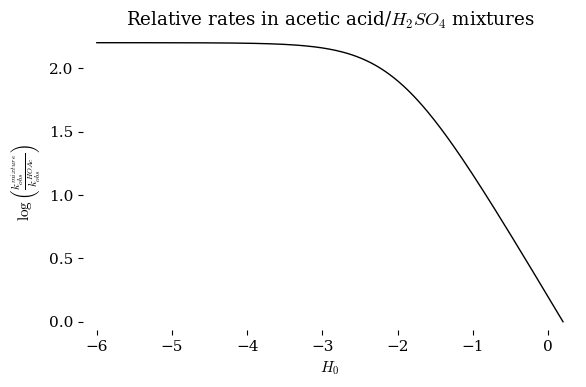

In [6]:
pKa = -2
H0_start = 0.2
H0_series = np.linspace(0.2, -6, 200)

f_start = 10**(-H0_start)/(10**(-pKa)+10**(-H0_start))

f_series = 10**(-H0_series)/(10**(-pKa)+10**(-H0_series))
#display(f_series)
#display(f_start)

relative_rate_series = f_series/f_start

# Make Plot

x = H0_series
y = relative_rate_series


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))  

ax.set(title=r"Relative rates in acetic acid/$H_2SO_4$ mixtures",       
       ylabel=r"$\log \left( \frac{k_{obs}^{mixture}}{k_{obs}^{HOAc}} \right)$", 
       xlabel=r"$H_0$",                
#       xlim=[9.5,13],                  
#       ylim=[17,21.5]
      )                   

ax.margins(x=.03, y=.03, tight=True)
plt.plot(x,np.log10(y),"-")


plt.show()

Interesting.  When the $H_0$ is above the $pK_a$, the rate increases linearly with increasing acid activity. A 10-fold increase in acidity will give a 10-fold increase in rate. But when $H_0$ is below the $pK_a$ we see the relative rate reach a maximum.